In [55]:
from IPython.core.display import HTML, display
import pickle
from warnings import filterwarnings
import pymc3 as pm
import theano.tensor as tt
from theano import shared

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from seaborn import heatmap
import matplotlib.pyplot as pl
from matplotlib import rcParams
from cmocean import cm as cmo

from pymc_utils import PyMCModel
from pymc_utils import subset_significant_feature

In [56]:
filterwarnings('ignore', category=UserWarning)

In [2]:
display(HTML("<style>.container {width: 90% !important}</style>"))

In [3]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16

In [4]:
def bayes_nn_model_l1_h(X, y_obs, n_hidden=None, lklhd_name='likelihood', include_bias=False,
                       parameterize_elu=False):
    """
    Hierarchical Bayesian NN Implementation.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: number of hidden layer neurons,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    
    if n_hidden is None:
        n_hidden = num_feats
    
    with pm.Model() as model:
        
        """        
        if parameterize_elu:
        alpha_elu = pm.HalfNormal('alpha_elu', sd=1)
        else:
            alpha_elu = 1
        elu_init_scale1 = np.sqrt(2) * np.sqrt(2 / (num_feats + n_hidden))
        elu_init_scale2 = np.sqrt(2) * np.sqrt(2 / (n_hidden + 1))
        """        
        init_1 = np.random.randn(num_feats, n_hidden)# * elu_init_scale1
        init_2 = np.random.randn(n_hidden,)# * elu_init_scale2
        hyp_wi1_sd = pm.HalfCauchy('hyp_w_i_1_sd', beta=2.5)
        hyp_w1o_sd = pm.HalfCauchy('hyp_w_1_out_sd', beta=2.5)
        w_i_1 = pm.Normal('wts_i_1', mu=0, sd=hyp_wi1_sd, shape=(num_feats, n_hidden), 
                      testval=init_1)
        w_1_o = pm.Normal('wts_1_out', mu=0, sd=hyp_w1o_sd, shape=(n_hidden,),
                      testval=init_2)
        #w_i_1 = pm.Laplace('wts_i_1', mu=0, b=hyp_wi1_sd, shape=(num_feats, n_hidden),)
        #w_1_o = pm.Laplace('wts_1_out', mu=0, b=hyp_w1o_sd, shape=(n_hidden,))
        if include_bias:
            init_b1 = np.random.randn(n_hidden,)
            init_b2 = np.random.randn()
            b1 = pm.Normal('bias_1', mu=0, sd=1, shape=(n_hidden,))
            b2 = pm.Normal('bias_out', mu=0, sd=1, shape=(1,))
        else:
            b1=b2=0
        lyr1_act = pm.Deterministic('layer1_act', tt.nnet.relu(tt.dot(X, w_i_1), #alpha=alpha_elu
                                                              ) + b1)
        out_act = pm.Deterministic('out_act', tt.dot(lyr1_act, w_1_o) + b2)
        
        sd = pm.HalfCauchy('sd', beta=2.5)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model


def bayes_nn_l2_h(X, y_obs, n_hidden1, n_hidden2, lklhd_name='likelihood', include_bias=False,
                 #parameterize_elu=False
                 ):
    """
    Hierarchical Bayesian NN Implementation.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: number of hidden layer neurons,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    """elu_init_scale1 = np.sqrt(2) * np.sqrt(2 / (num_feats + n_hidden1))
    elu_init_scale2 = np.sqrt(2) * np.sqrt(2 / (n_hidden1 + n_hidden2))"""
    with pm.Model() as model:
        """
        if parameterize_elu:
            alpha_elu = pm.HalfNormal('alpha_elu', sd=1, shape=(2,))
        else:
            alpha_elu = [1, 1]"""
        init_1 = np.random.randn(num_feats, n_hidden1)# * elu_init_scale1
        init_2 = np.random.randn(n_hidden1, n_hidden2)# * elu_init_scale2
        init_3 = np.random.randn(n_hidden2,)
        if include_bias:   
            init_b1 = np.random.randn(n_hidden1,)
            init_b2 = np.random.randn(n_hidden2,)
            init_b3 = np.random.randn()
            b1 = pm.Normal('bias_layer1', mu=0, sd=1, shape=(n_hidden1,),
                           testval=init_b1)
            b2 = pm.Normal('bias_layer2', mu=0, sd=1, shape=(n_hidden2,),
                          testval=init_b2)
            b3 = pm.Normal('bias_layer3', mu=0, sd=1, testval=init_b3)
        else:
            b1 = b2 = b3 = 0
        hyper_w1_sd = pm.HalfCauchy('hyper_w1_sd', beta=1)
        hyper_w2_sd = pm.HalfCauchy('hyper_w2_sd', beta=1)
        hyper_w3_sd = pm.HalfCauchy('hyper_w3_sd', beta=1)
        w1 = pm.Normal('wts_i_1', mu=0, sd=hyper_w1_sd, shape=(num_feats, n_hidden1), 
                      testval=init_1)
        w2 = pm.Normal('wts_1_2', mu=0, sd=hyper_w2_sd, shape=(n_hidden1, n_hidden2),
                      testval=init_2)
        w3 = pm.Normal('wts_2_out', mu=0, sd=hyper_w3_sd, shape=(n_hidden2,),
                      testval=init_3)
        lyr1_act = pm.Deterministic('layer1_act', tt.nnet.relu(tt.dot(X, w1),
                                                              #alpha=alpha_elu[0]
                                                              ) + b1)
        lyr2_act = pm.Deterministic('layer2_act', tt.nnet.relu(tt.dot(lyr1_act, w2),
                                                              #alpha=alpha_elu[1]
                                                              ) + b2)
        out_act = pm.Deterministic('layer3_act', tt.dot(lyr2_act, w3) + b3)
        
        sd = pm.HalfCauchy('sd', beta=2.5)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model


def bayes_nn_l3_h(X, y_obs, n_hidden1, n_hidden2, n_hidden3, lklhd_name='likelihood', include_bias=False):
    """
    Hierarchical Bayesian NN Implementation.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: number of hidden layer neurons,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    elu_init_scale1 = np.sqrt(2) * np.sqrt(2 / (num_feats + n_hidden1))
    elu_init_scale2 = np.sqrt(2) * np.sqrt(2 / (n_hidden1 + n_hidden2))
    elu_init_scale3 = np.sqrt(2) * np.sqrt(2 / (n_hidden2 + n_hidden3))
    elu_init_scale4 = np.sqrt(2) * np.sqrt(2 / (n_hidden3 + 1))
    with pm.Model() as model:
        
        init_1 = np.random.randn(num_feats, n_hidden1) * elu_init_scale1
        init_2 = np.random.randn(n_hidden1, n_hidden2) * elu_init_scale2
        init_3 = np.random.randn(n_hidden2, n_hidden3) * elu_init_scale3
        init_4 = np.random.randn(n_hidden3,) * elu_init_scale4
        if include_bias:   
            init_b1 = np.random.randn(n_hidden1,)
            init_b2 = np.random.randn(n_hidden2,)
            init_b3 = np.random.randn(n_hidden3,)
            init_b4 = np.random.randn()
            b1 = pm.Normal('bias_layer1', mu=0, sd=1, shape=(n_hidden1,),
                           testval=init_b1)
            b2 = pm.Normal('bias_layer2', mu=0, sd=1, shape=(n_hidden2,),
                          testval=init_b2)
            b3 = pm.Normal('bias_layer3', mu=0, sd=1, shape=(n_hidden3,),
                           testval=init_b3)
            b4 = pm.Normal('bias_layer4', mu=0, sd=1, testval=init_b4)
            
        else:
            b1 = b2 = b3 = b4 = 0
        hyper_w1_sd = pm.HalfCauchy('hyper_w1_sd', beta=1)
        hyper_w2_sd = pm.HalfCauchy('hyper_w2_sd', beta=1)
        hyper_w3_sd = pm.HalfCauchy('hyper_w3_sd', beta=1)
        hyper_w4_sd = pm.HalfCauchy('hyper_w4_sd', beta=1)
        w1 = pm.Normal('wts_i_1', mu=0, sd=hyper_w1_sd, shape=(num_feats, n_hidden1), 
                      testval=init_1)
        w2 = pm.Normal('wts_1_2', mu=0, sd=hyper_w2_sd, shape=(n_hidden1, n_hidden2),
                      testval=init_2)
        w3 = pm.Normal('wts_2_3', mu=0, sd=hyper_w3_sd, shape=(n_hidden2, n_hidden3),
                      testval=init_3)
        w4 = pm.Normal('wts_3_out', mu=0, sd=hyper_w4_sd, shape=(n_hidden3,))
        lyr1_act = pm.Deterministic('layer1_act', tt.nnet.elu(tt.dot(X, w1)) + b1)
        lyr2_act = pm.Deterministic('layer2_act', tt.nnet.elu(tt.dot(lyr1_act, w2)) + b2)
        lyr3_act = pm.Deterministic('layer3_act', tt.nnet.elu(tt.dot(lyr2_act, w3)) + b3)
        out_act = pm.Deterministic('out_act', tt.dot(lyr3_act, w4) + b4)
        
        sd = pm.HalfCauchy('sd', beta=2.5)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model

In [5]:
band = 670
ds = pd.read_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_SWF.pkl')
ds['log10_aphy%d' % band] = np.log10(ds.loc[:, 'aphy%d' % band])
ds.to_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_SWF.pkl')

In [6]:
ds.describe().T

,count,mean,std,min,25%,50%,75%,max
sin_doy_s,162.0,-7.538551e-17,1.003101,-1.632361,-1.075398,0.291772,0.919767,1.067988
cos_doy_s,162.0,3.807825e-17,1.003101,-1.729100,-0.778317,0.208898,0.685304,1.430161
sin_minofday_s,162.0,1.915477e-16,1.003101,-0.599067,-0.553291,-0.397313,0.053463,4.165531
cos_minofday_s,162.0,-2.193033e-17,1.003101,-1.835295,-0.763772,0.101973,0.788677,2.063419
x_s,162.0,-1.045117e-16,1.003101,-2.523305,0.067800,0.101626,0.322978,2.480050
y_s,162.0,-6.030841e-17,1.003101,-0.570194,-0.540412,-0.281825,-0.081228,4.415726
z_s,162.0,-1.096945e-16,1.003101,-4.151014,0.121210,0.153920,0.480512,1.370943
log10_etopo2_s,162.0,-1.398059e-16,1.003101,-1.962412,-0.768789,-0.369002,0.760279,1.745110
oisst_s,162.0,2.193033e-17,1.003101,-2.990826,-0.781122,0.070849,0.976256,1.396973
solz_s,162.0,-1.072530e-16,1.003101,-1.851402,-0.753258,0.127265,0.760037,1.757741


In [7]:
feat_beg = 'sin_doy_s'
feat_end_ni = 'PC6_s'

X_s = ds.dropna().loc[:, :feat_end_ni]
lbls_X_s = X_s.columns.tolist()
y = ds.dropna().loc[:, 'log10_aphy%d' % band]

In [8]:
X_s_train, X_s_test, y_train, y_test = train_test_split(X_s, y, test_size=0.1,
                                                       random_state=42)

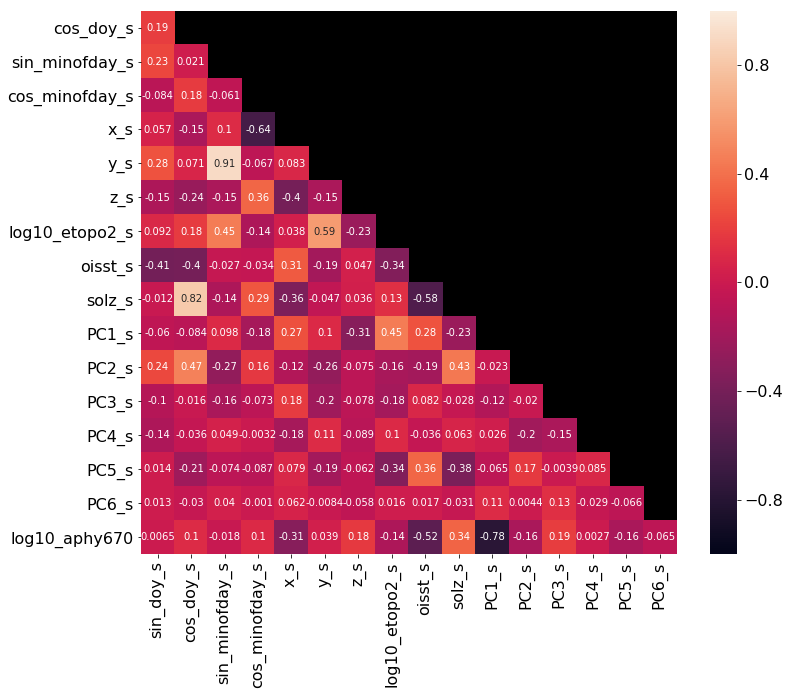

In [9]:
Xy_train = pd.concat((X_s_train, y_train), axis=1)
f, ax = pl.subplots(figsize=(12, 10))
heatmap(Xy_train.corr().iloc[1:,:-1],vmin=-1, vmax=1, mask=np.triu(np.ones([Xy_train.shape[1]-1] * 2),k=1), ax=ax,
        annot=True, annot_kws={'fontsize': 10})
ax.set_facecolor('k')

In [10]:
subset_feats = ['oisst_s', 'PC1_s', 'PC2_s', 'PC3_s', 'PC4_s', 'PC5_s', 'PC6_s']
X_s_subset = ds.dropna().loc[:, subset_feats]
X_s_sub_train, X_s_sub_test, ysub_train, ysub_test = train_test_split(X_s_subset, y,
                                                                     test_size=0.1,
                                                                     random_state=42)

### Fitting w/ All Features - No Interactions

####  <u>Model 1: Single Layer BNN</u>

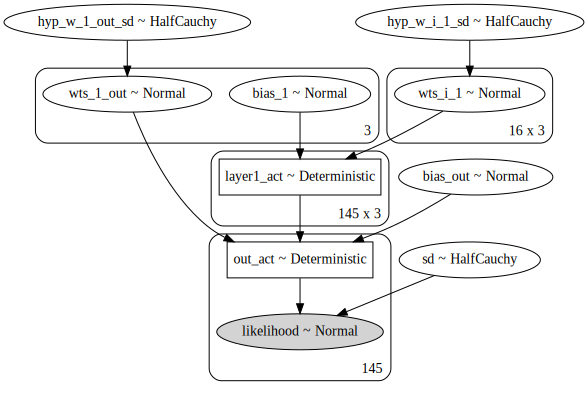

In [11]:
X_shared = shared(X_s_train.values)
bnn_l1 = PyMCModel(bayes_nn_model_l1_h, X_shared, y_train, n_hidden=3, include_bias=True)
bnn_l1.show_model()

In [12]:
# Fit Posterior
bnn_l1.fit_ADVI()

Average Loss = 105.24: 100%|██████████| 100000/100000 [00:45<00:00, 2208.84it/s]
Finished [100%]: Average Loss = 105.2


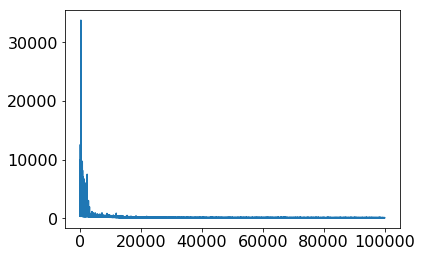

In [13]:
# Check convergence
pl.plot(bnn_l1.approx_fit.hist)

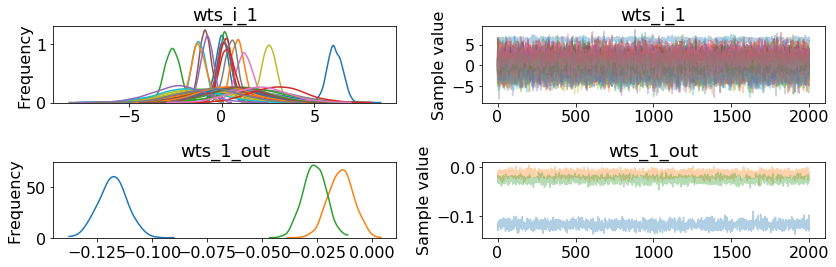

In [14]:
bnn_l1.evaluate_fit(['wts_i_1', 'wts_1_out']);

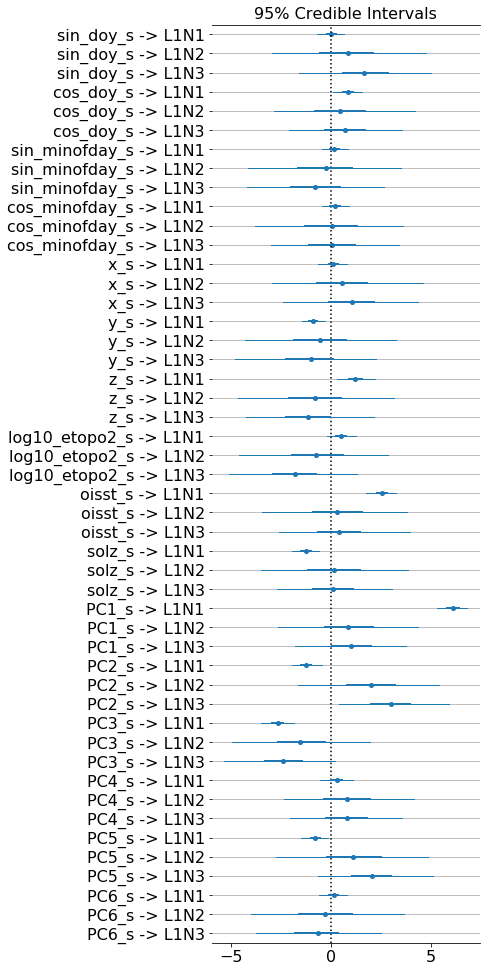

In [15]:
labels = ['%s -> L1N%d' %(li, ni) for li in lbls_X_s for ni in range(1, 4)]
bnn_l1.show_forest(['wts_i_1'], feat_labels=labels)
f = pl.gcf()
f.set_figheight(15);

100%|██████████| 2000/2000 [00:01<00:00, 1506.52it/s]


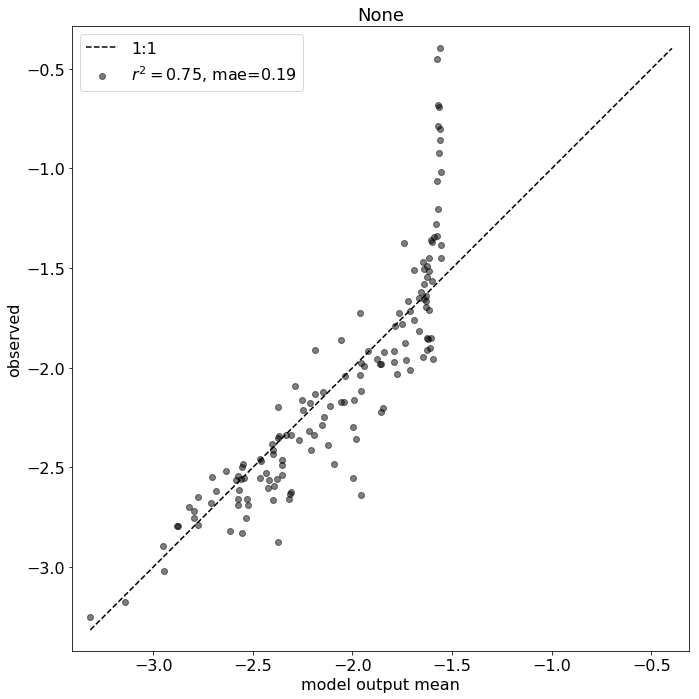

In [16]:
# Check fit on training model
ppc_train_l1 = bnn_l1.predict(X_shared, likelihood_name='likelihood')
bnn_l1.plot_model_fits(y_train, ppc_train_l1, loss_metric='mae', );

100%|██████████| 2000/2000 [00:01<00:00, 1179.25it/s]


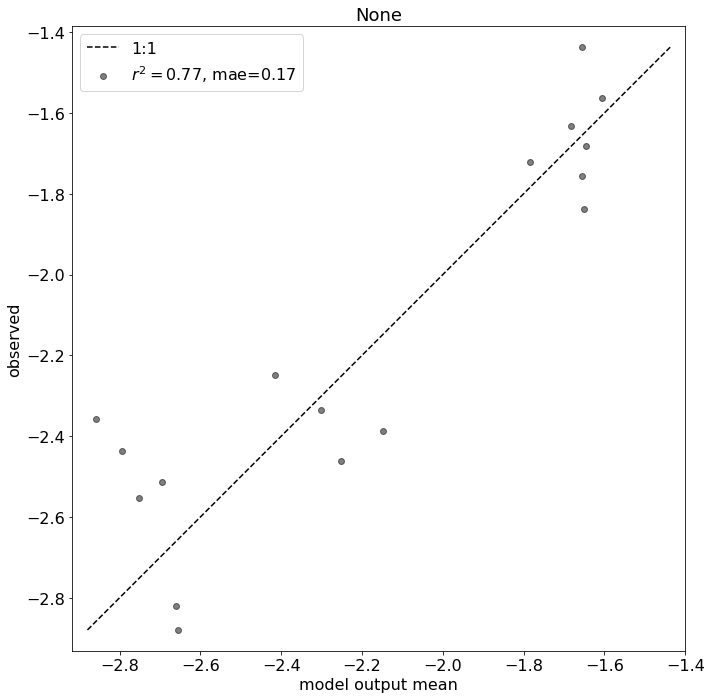

In [17]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_l1 = bnn_l1.predict(X_shared, likelihood_name='likelihood')
bnn_l1.plot_model_fits(y_test, ppc_test_l1, loss_metric='mae',);

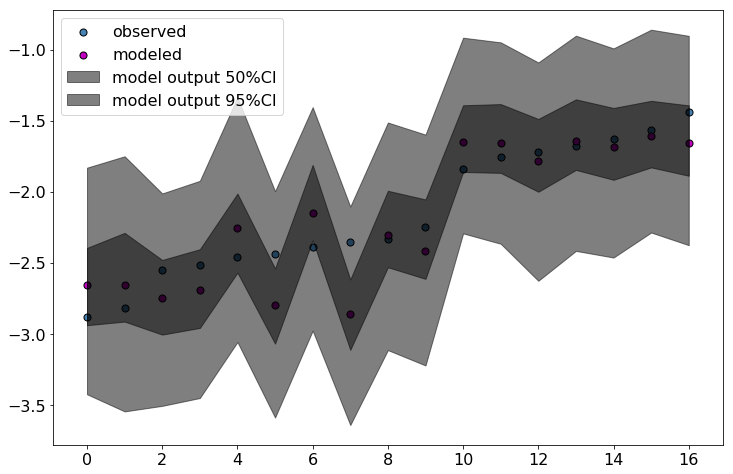

In [18]:
# Plot Fits with Uncertainty Estimates
iy  = np.argsort(y_test)
ix = np.arange(iy.size)
ppc_test = ppc_test_l1
lik_mean =ppc_test.mean(axis=0)
lik_hpd = pm.hpd(ppc_test)
lik_hpd_05 = pm.hpd(ppc_test, alpha=0.5)

f_fit2, ax = pl.subplots(figsize=(12, 8))
ax.scatter(ix, y_test.values[iy], label='observed', edgecolor='k', s=50,
           color='steelblue');
ax.scatter(ix, lik_mean[iy], label='modeled', edgecolor='k', s=50, color='m')

ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], alpha=0.5, color='k',
               label='model output 50%CI');
ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], alpha=0.5, color='k',
               label='model output 95%CI');
ax.legend(loc='upper left');
#f_fit2.savefig('./figJar/bayesNet/bNN_L1_nobias.png', dpi=300, format='png')

<u>Re-Train Model with Entire Data Set for Inter-Model Comparison</u>

In [19]:
X_shared = shared(X_s.values)
bnn_l1 = PyMCModel(bayes_nn_model_l1_h, X_shared, y, n_hidden=3, include_bias=True)

In [20]:
bnn_l1.fit_ADVI()

Average Loss = 66.775: 100%|██████████| 100000/100000 [00:45<00:00, 2180.74it/s]
Finished [100%]: Average Loss = 66.706


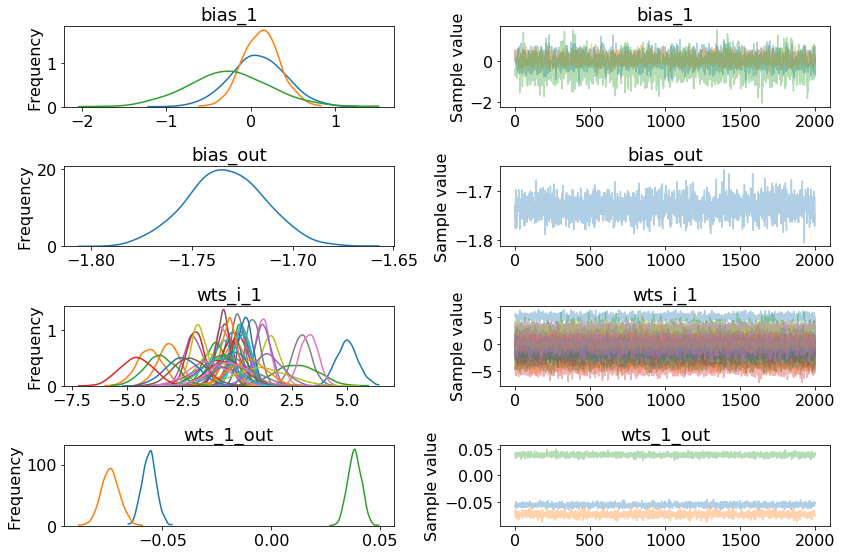

In [21]:
bnn_l1.evaluate_fit(['bias_1', 'bias_out', 'wts_i_1', 'wts_1_out']);

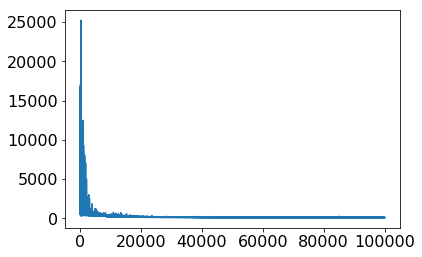

In [22]:
pl.plot(bnn_l1.approx_fit.hist);

100%|██████████| 2000/2000 [00:01<00:00, 1462.30it/s]


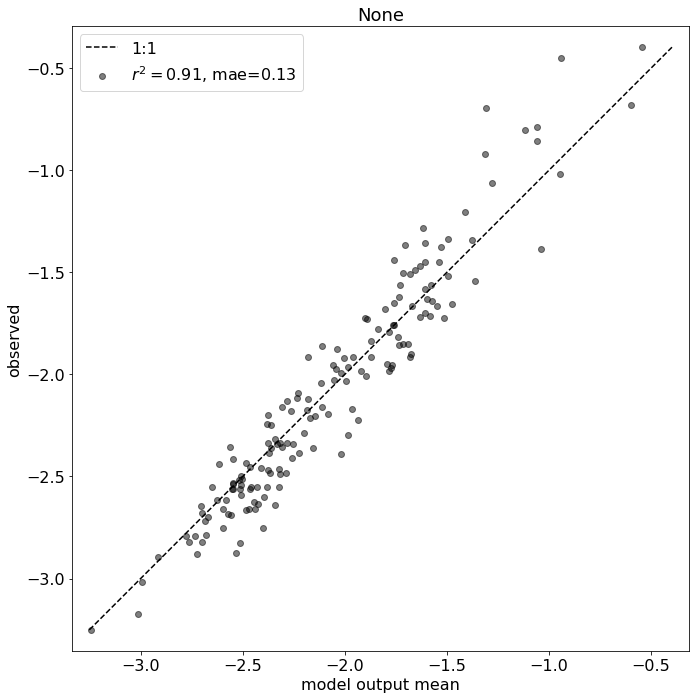

In [23]:
ppc_l1 = bnn_l1.predict(X_shared, likelihood_name='likelihood')
bnn_l1.plot_model_fits(y, ppc_l1, loss_metric='mae');

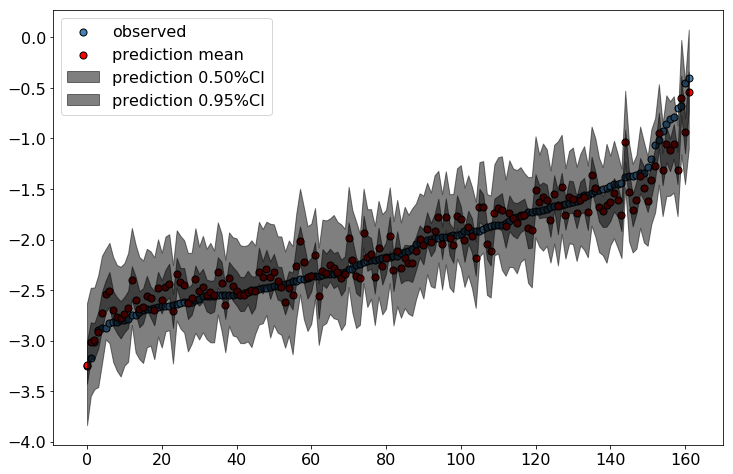

In [24]:
_, ax = pl.subplots(figsize=(12, 8))
ax = bnn_l1.plot_model_ppc_stats(ppc_l1, y, ax=ax)

### Fitting w/ PCs only
####  <u>Model 2: Single Layer BNN</u>

In [25]:
# extract pc columns
X_s_train_pc = X_s_train.filter(regex='PC', axis=1)
X_s_test_pc = X_s_test.filter(regex='PC', axis=1)

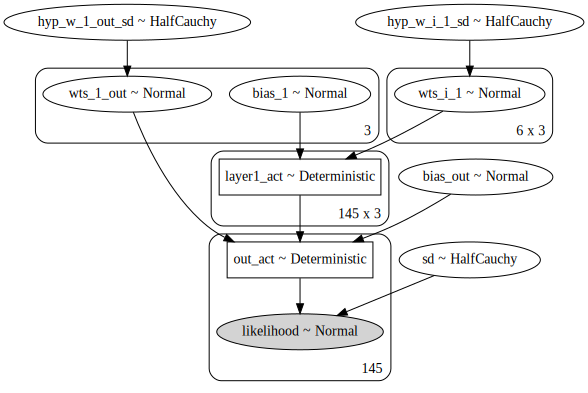

In [26]:
X_shared_pc = shared(X_s_train_pc.values)
bnn_l1_pc = PyMCModel(bayes_nn_model_l1_h, X_shared_pc, y_train, n_hidden=3, include_bias=True)
bnn_l1_pc.show_model()

In [27]:
bnn_l1_pc.fit_ADVI()

Average Loss = 57.606: 100%|██████████| 100000/100000 [00:45<00:00, 2206.73it/s]
Finished [100%]: Average Loss = 57.644


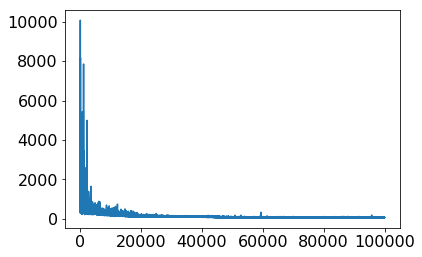

In [28]:
pl.plot(bnn_l1_pc.approx_fit.hist);

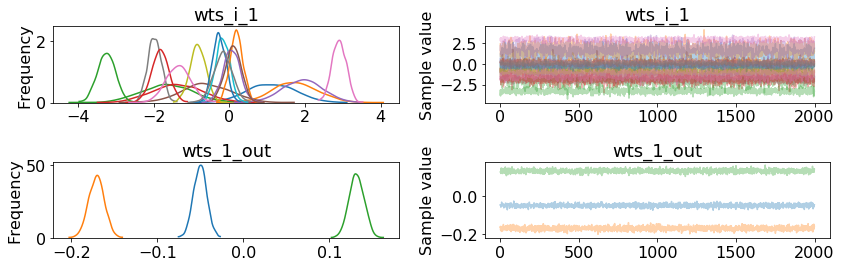

In [29]:
bnn_l1_pc.evaluate_fit(['wts_i_1', 'wts_1_out']);

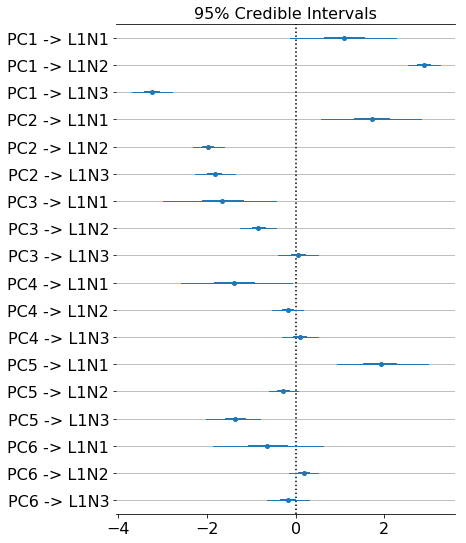

In [30]:
labels = ['PC%d -> L1N%d' %(i, ni) for i in range(1, 7) for ni in range(1, 4)]
bnn_l1_pc.show_forest(['wts_i_1'], feat_labels=labels);
f = pl.gcf()
f.set_figheight(8);

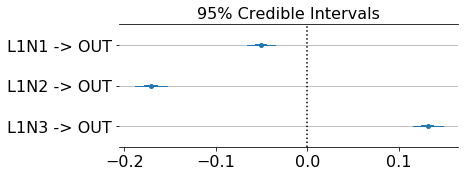

In [31]:
labels = ['L1N%d -> OUT' %i for i in range(1, 4) ]
bnn_l1_pc.show_forest(['wts_1_out'], feat_labels=labels);
f = pl.gcf()
f.set_figheight(2);

100%|██████████| 2000/2000 [00:01<00:00, 1498.30it/s]


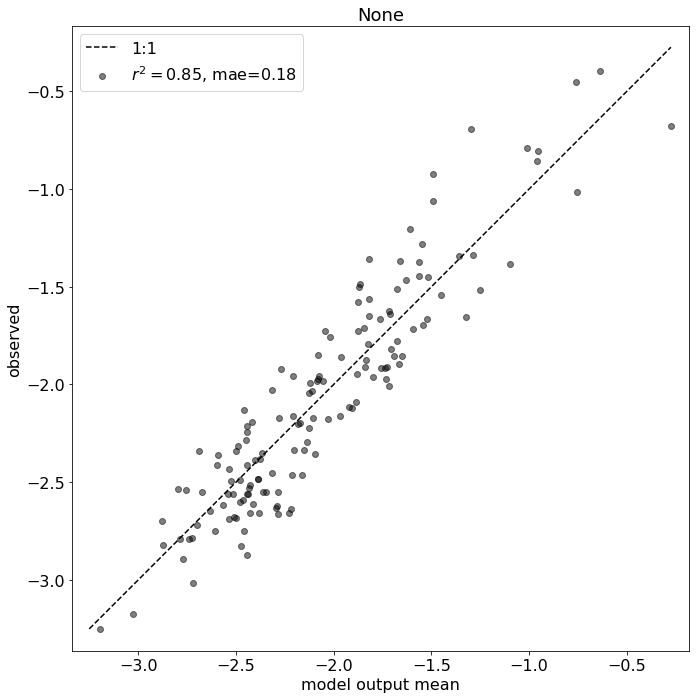

In [32]:
# Check Training Data Fit
ppc_train_l1_pc = bnn_l1_pc.predict(X_shared_pc, likelihood_name='likelihood')
bnn_l1_pc.plot_model_fits(y_train, ppc_train_l1_pc, loss_metric='mae',);

In [33]:
#Check Test Data Fit
X_shared_pc.set_value(X_s_test.filter(regex='PC').values)
ppc_test_l1_pc = bnn_l1_pc.predict(X_shared_pc, likelihood_name='likelihood')

100%|██████████| 2000/2000 [00:01<00:00, 1139.03it/s]


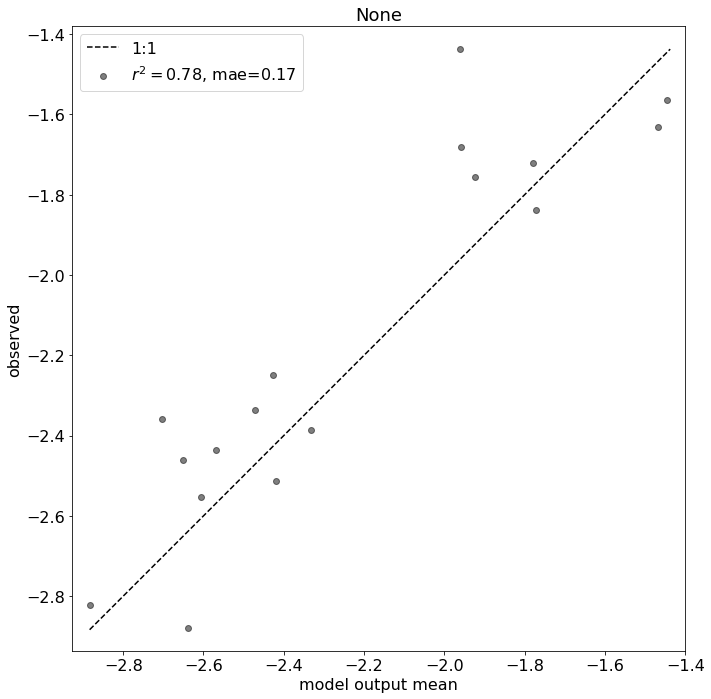

In [34]:
bnn_l1_pc.plot_model_fits(y_test, ppc_test_l1_pc, loss_metric='mae',);

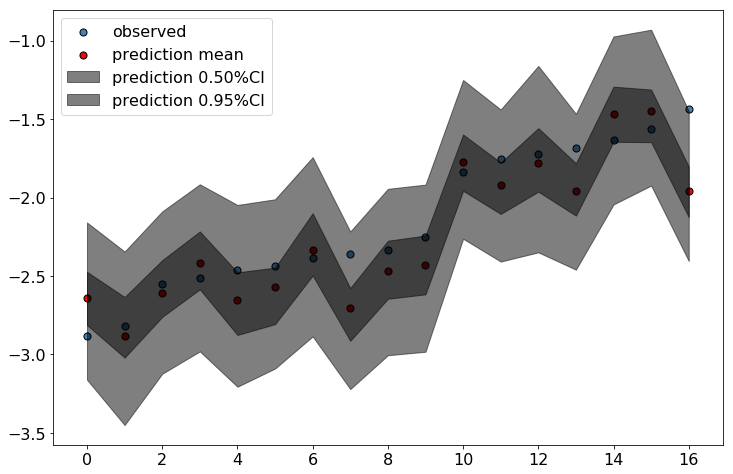

In [35]:
_, ax = pl.subplots(figsize=(12, 8))
ax = bnn_l1_pc.plot_model_ppc_stats(ppc_test_l1_pc, y_test, ax=ax)

<u>Retrain Model with Complete Dataset</u>

In [36]:
X_shared_pc = shared(X_s.filter(regex='PC', axis=1).values)
bnn_l1_pc = PyMCModel(bayes_nn_model_l1_h, X_shared_pc, y, n_hidden=3, include_bias=True)

In [37]:
bnn_l1_pc.fit_ADVI()

Average Loss = 56.764: 100%|██████████| 100000/100000 [00:46<00:00, 2173.68it/s]
Finished [100%]: Average Loss = 56.758


100%|██████████| 2000/2000 [00:01<00:00, 1505.11it/s]


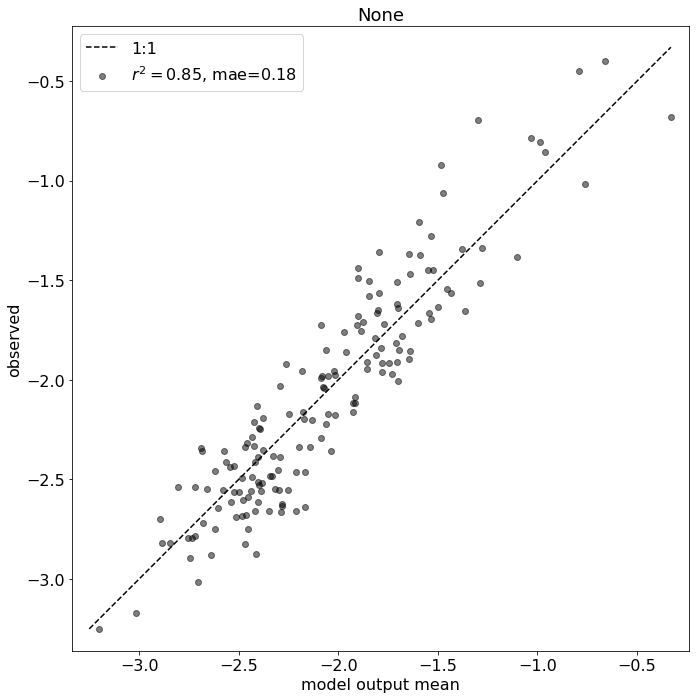

In [38]:
ppc_l1_pc = bnn_l1_pc.predict(X_shared_pc, likelihood_name='likelihood')
bnn_l1_pc.plot_model_fits(y, ppc_l1_pc, loss_metric='mae',);

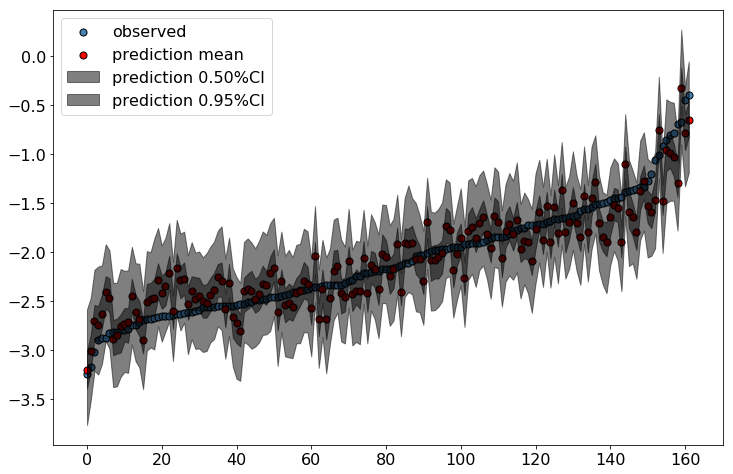

In [39]:
_, ax = pl.subplots(figsize=(12, 8))
ax = bnn_l1_pc.plot_model_ppc_stats(ppc_l1_pc, y, ax=ax)

### Fitting w/ PCs  and SST

#### <u>Model 3: Single Hidden Layer</u>

In [40]:
subset_feats

['oisst_s', 'PC1_s', 'PC2_s', 'PC3_s', 'PC4_s', 'PC5_s', 'PC6_s']

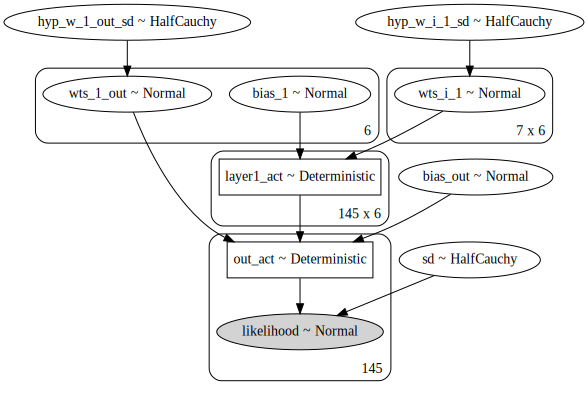

In [41]:
X_shared_sub = shared(X_s_sub_train.values)
bnn_l1_sub = PyMCModel(bayes_nn_model_l1_h, X_shared_sub, ysub_train, n_hidden=6, include_bias=True)
bnn_l1_sub.show_model()

In [42]:
bnn_l1_sub.fit_ADVI()

Average Loss = 53.067: 100%|██████████| 100000/100000 [00:52<00:00, 1907.67it/s]
Finished [100%]: Average Loss = 53.109


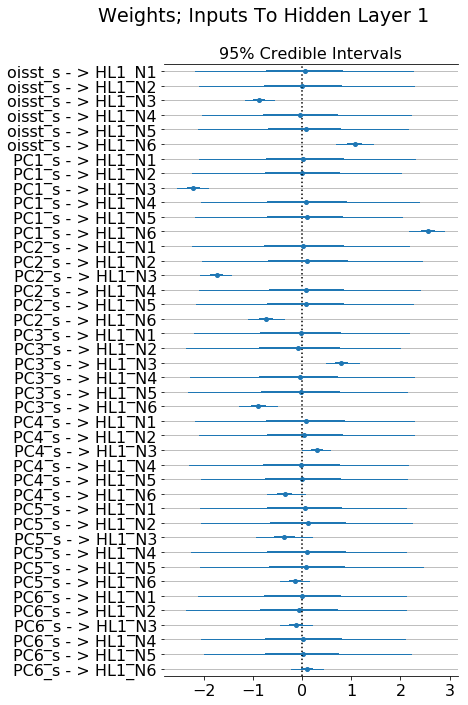

In [43]:
labels = ['%s - > HL1_N%d' %(li, l1) for li in subset_feats  for l1 in range(1, 7)]
bnn_l1_sub.show_forest(['wts_i_1'], feat_labels=labels);
f = pl.gcf()
f.set_figheight(10)
f.suptitle('Weights; Inputs To Hidden Layer 1');

100%|██████████| 2000/2000 [00:01<00:00, 1494.19it/s]


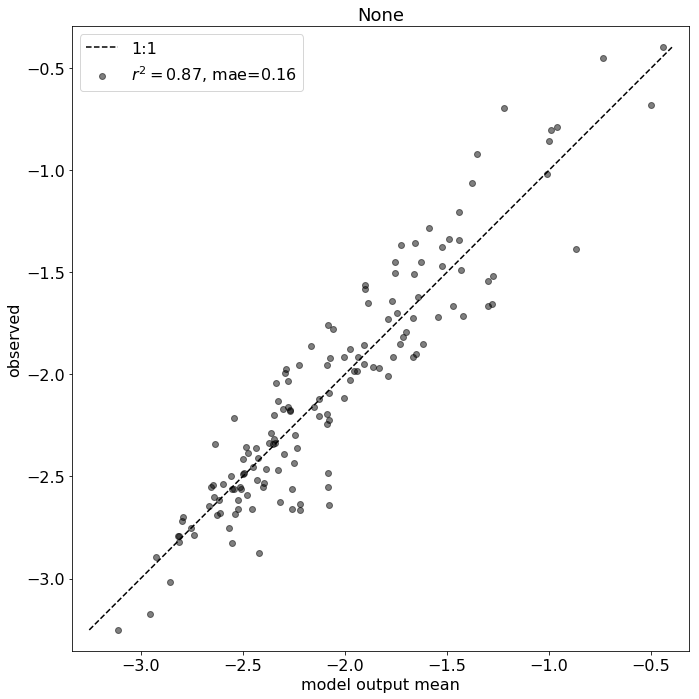

In [44]:
# Check Training Data Fit
ppc_train_l1_sub = bnn_l1_sub.predict(X_shared_sub, likelihood_name='likelihood')
bnn_l1_sub.plot_model_fits(ysub_train, ppc_train_l1_sub, loss_metric='mae',);

100%|██████████| 2000/2000 [00:01<00:00, 1150.66it/s]


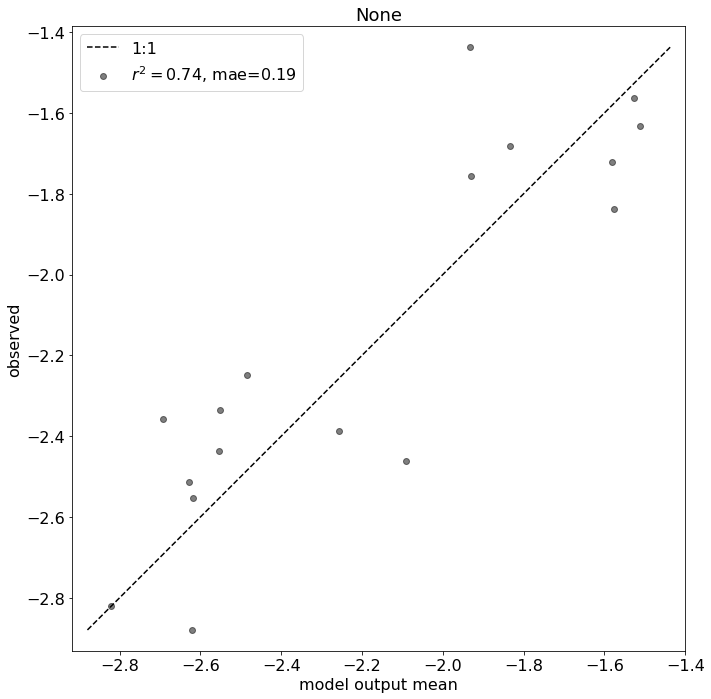

In [45]:
X_shared_sub.set_value(X_s_sub_test)
ppc_test_l1_sub = bnn_l1_sub.predict(X_shared_sub, likelihood_name='likelihood')
bnn_l1_sub.plot_model_fits(ysub_test, ppc_test_l1_sub, loss_metric='mae',);

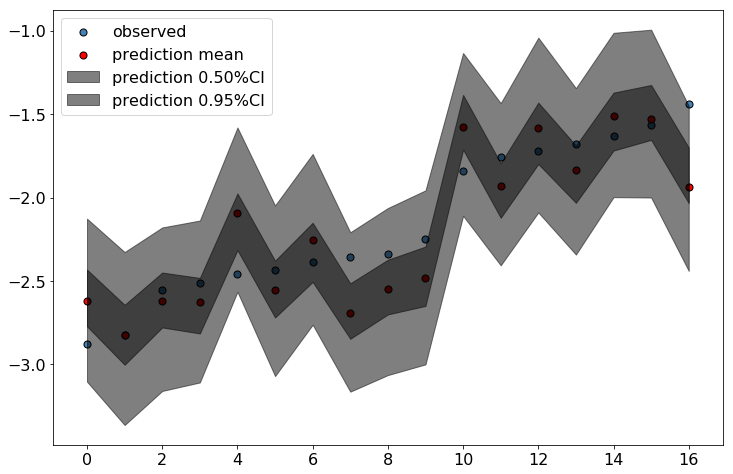

In [46]:
_, ax = pl.subplots(figsize=(12, 8))
ax = bnn_l1_sub.plot_model_ppc_stats(ppc_test_l1_sub, y_test, ax=ax)

<u> Retrain Model w/ Complete DataSet</u>

In [47]:
X_shared_sub = shared(X_s_subset.values)
bnn_l1_sub = PyMCModel(bayes_nn_model_l1_h, X_shared_sub, y, n_hidden=6, include_bias=True)

In [48]:
bnn_l1_sub.fit_ADVI()

Average Loss = 52.378: 100%|██████████| 100000/100000 [00:46<00:00, 2138.38it/s]
Finished [100%]: Average Loss = 52.352


100%|██████████| 2000/2000 [00:01<00:00, 1436.99it/s]


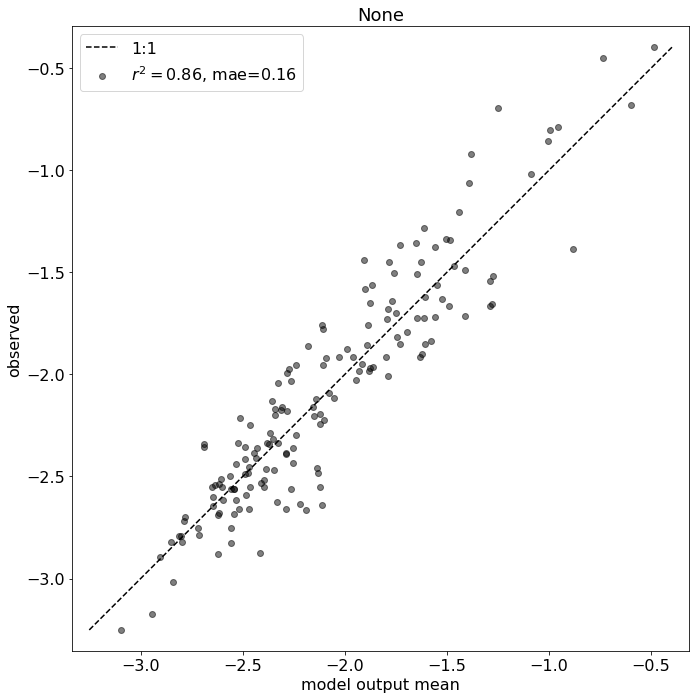

In [49]:
ppc_l1_sub = bnn_l1_sub.predict(X_shared_sub, likelihood_name='likelihood')
bnn_l1_sub.plot_model_fits(y, ppc_l1_sub, loss_metric='mae',);

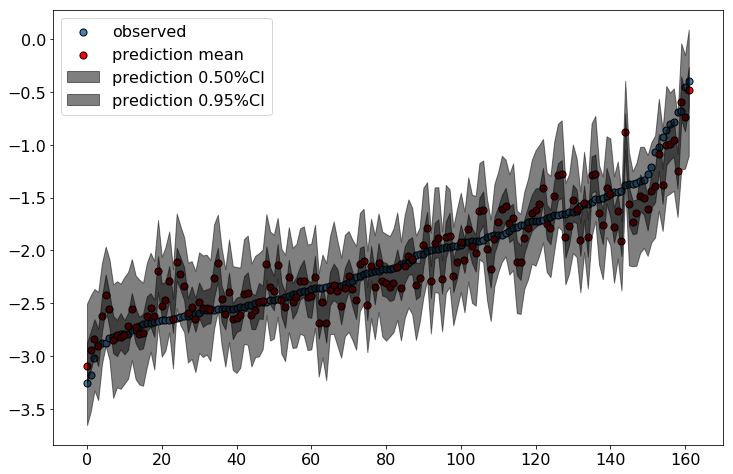

In [50]:
_, ax = pl.subplots(figsize=(12, 8))
ax = bnn_l1_sub.plot_model_ppc_stats(ppc_l1_sub, y, ax=ax)

Can't get good results with a 2-layer model - needs more data!
<br>
<br>
### <u>Retraining All Models with Complete (Training + Test) Dataset for Inter-Model WAIC & LOO Comparison</u>

In [51]:
subset_feats

['oisst_s', 'PC1_s', 'PC2_s', 'PC3_s', 'PC4_s', 'PC5_s', 'PC6_s']

In [57]:
bnn_l1.model.name = 'L1_BNN_aphi%d' % band
bnn_l1_pc.model.name = 'L1_BNN_aphi%d_pc' % band
bnn_l1_sub.model.name = 'L1_BNN_aphi%d_pc_sst'%band
model_dict = {bnn_l1.model: bnn_l1.trace_,
             bnn_l1_pc.model: bnn_l1_pc.trace_,
             bnn_l1_sub.model: bnn_l1_sub.trace_
             }
pm.compare(model_dict=model_dict)

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
L1_BNN_aphi670_pc_sst,13.79,25.93,0,0.53,17.03,0,1
L1_BNN_aphi670_pc,26.57,25.3,12.78,0.12,15.58,14.16,1
L1_BNN_aphi670,27.28,52.2,13.5,0.36,18.54,17.98,1


In [58]:
pm.compare(model_dict, ic='LOO')

,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
L1_BNN_aphi670_pc_sst,19.25,28.66,0,0.57,17.67,0,1
L1_BNN_aphi670_pc,33.2,28.61,13.95,0.22,17.03,15.08,1
L1_BNN_aphi670,52.4,64.76,33.15,0.21,20.73,19.93,1


In [54]:
pickledModelDict = {bnn_l1.model.name: bnn_l1,
                   bnn_l1_pc.model.name: bnn_l1_pc,
                   bnn_l1_sub.model.name: bnn_l1_sub}
with open('./pickleJar/Models/Aphi%d_BNN.pkl' % band, 'wb') as f:
    pickle.dump(pickledModelDict, f, protocol=pickle.HIGHEST_PROTOCOL)